# Comparacion de algoritmos con dataset publico SWaT

## Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/TFM_Sohrab/SWaT

/content/drive/MyDrive/TFM_Sohrab/SWaT


In [ ]:
%ls

SWaT_Dataset_Attack_v0.csv  SWaT_Dataset_Normal_v1.csv  USAD.ipynb


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install pyod            # normal install

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.0-py3-none-any.whl size=185329 sha256=75738152ba29fb78b93ca676f34a24d1c0e73c66a3a838b4e6e126f8c641cadb
  Stored in directory: /root/.cache/pip/wheels/36/8e/e2/e932956b10b843eb6be9eefa70b5c1bee7b561be14c423b136
Successfully built pyod


## EDA - Data Pre-Processing

### Download dataset

In [ ]:
!mkdir input
#normal period
!python gdrivedl.py https://drive.google.com/open?id=1rVJ5ry5GG-ZZi5yI4x9lICB8VhErXwCw input/
#anomalies
!python gdrivedl.py https://drive.google.com/open?id=1iDYc0OEmidN712fquOBRFjln90SbpaE7 input/

### Normal period

In [ ]:
#Read data
normal = pd.read_csv("input/SWaT_Dataset_Normal_v1.csv")#, nrows=1000)
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
normal.shape

<ipython-input-6-03f4bd0547d1>:2: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  normal = pd.read_csv("SWaT_Dataset_Normal_v1.csv")#, nrows=1000)


(495000, 51)

In [ ]:
memory_usage = normal.memory_usage(deep=True).sum()

# Print the memory usage
print("Memory usage:", memory_usage)

Memory usage: 901706189


In [ ]:
# Transform all columns into float64
for i in list(normal):
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)

#### Normalization

In [ ]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [ ]:
normal.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.0,0.005294,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0
1,0.0,0.005407,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0


### Test
Contiene tanto datos normales como de ataque

In [ ]:
#Read data
test = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv")#, nrows=1000)
labels = [ float(label!= 'Normal' ) for label  in test["Normal/Attack"].values]
test = test.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
test.shape

(449919, 51)

In [ ]:
memory_usage = test.memory_usage(deep=True).sum()

# Print the memory usage
print("Memory usage:", memory_usage)

Memory usage: 183567080


In [ ]:
# Transform all columns into float64
test = test.astype(float)

#### Normalization

In [ ]:
x = test.values
x_scaled = min_max_scaler.transform(x)
test = pd.DataFrame(x_scaled)

In [ ]:
test.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.884144,0.577133,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944116,0.000073,0.0,0.0,0.0
1,0.891145,0.577190,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944521,0.000073,0.0,0.0,0.0


## Z-score
Este modelo al no tener parte de entrenamiento, lo aplicaremos directamente sobre los datos de test para luego calcular las metricas para comparacion.

F1-Score: 0.4535500879610479
Precision: 0.3115944013804815
Recall: 0.8330861756467293


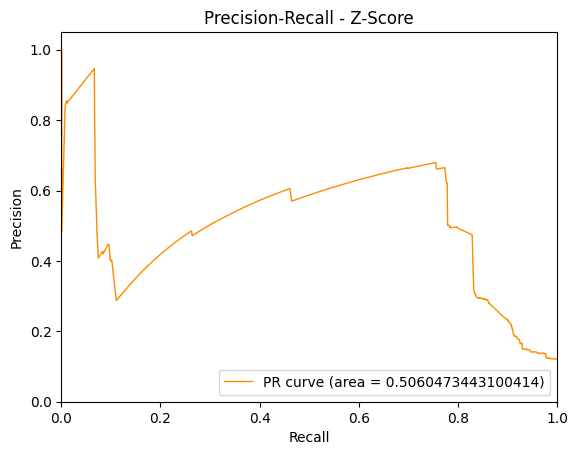

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Step 1: Calculate Z-scores
z_scores = (test - test.mean()) / test.std()

# Step 2: Identify anomalies (using a threshold of 2.5 for demonstration). If any variable is bigger than 2.5, then the instance is an anomaly.
threshold = 2.5
y_zscore = (np.abs(z_scores) > threshold).any(axis=1).astype(int)

# Step 3: Calculate F1-Score, Precision, and Recall
f1 = f1_score(labels, y_zscore)
precision = precision_score(labels, y_zscore)
recall = recall_score(labels, y_zscore)

print(f"F1-Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Step 4: Plot AUC-ROC Curve
# Use the maximum Z-score among all features as the 'score' for each data point
max_z_scores = z_scores.abs().max(axis=1)

precision, recall, _ = precision_recall_curve(labels, max_z_scores)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=1, label=f'PR curve (area = {pr_auc})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall - Z-Score')
plt.legend(loc="lower right")
plt.show()


## KNN


F1-Score: 0.21654720182686057
Precision: 0.12142020357851822
Recall: 1.0


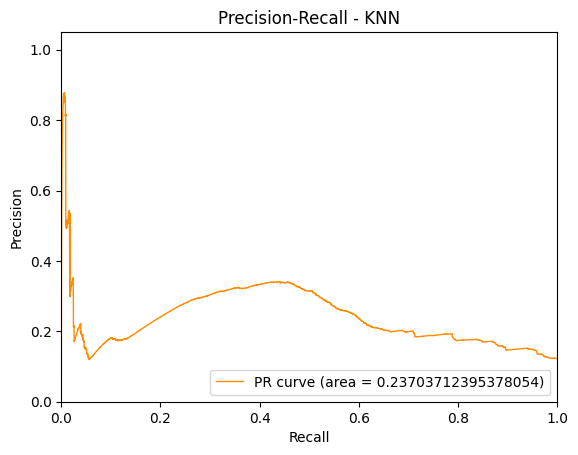

In [ ]:
from pyod.models.knn import KNN

# Step 1: Train the KNN model
clf = KNN(n_neighbors=3)
clf.fit(normal)

# Step 2: Predict anomalies
test_scores = clf.decision_function(test)  # Outlier scores
y_KNN = clf.predict(test)  # Binary prediction: 0 for inliers, 1 for outliers/anomalies

# Step 3: Calculate F1-Score, Precision, and Recall
f1 = f1_score(labels, y_KNN)
precision = precision_score(labels, y_KNN)
recall = recall_score(labels, y_KNN)

print(f"F1-Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


# Step 4: Plot AUC-PR Curve
precision, recall, _ = precision_recall_curve(labels, test_scores)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=1, label=f'PR curve (area = {pr_auc})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall - KNN')
plt.legend(loc="lower right")
plt.show()

##Principal Component Analysis (PCA)

F1-Score: 0.25917352604996297
Precision: 0.15118613862594674
Recall: 0.9070504018600904


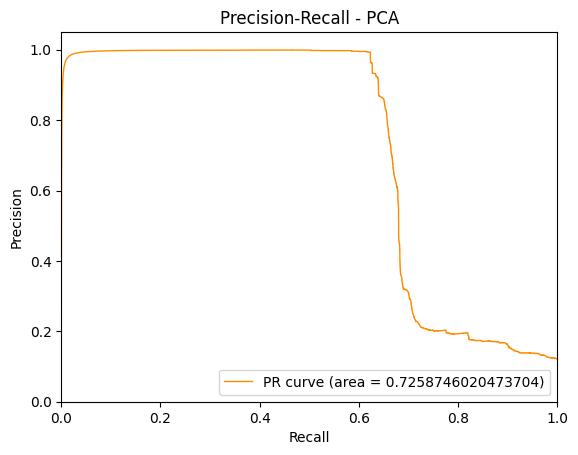

In [ ]:
from pyod.models.pca import PCA

# Step 1: Train the PCA model
clf = PCA(n_components=2)  # You can adjust the number of components as needed
clf.fit(normal)

# Step 2: Predict anomalies
test_scores = clf.decision_function(test)  # Outlier scores
y_pca = clf.predict(test)  # Binary prediction: 0 for inliers, 1 for outliers/anomalies

# Step 3: Calculate F1-Score, Precision, and Recall
f1 = f1_score(labels, y_pca)
precision = precision_score(labels, y_pca)
recall = recall_score(labels, y_pca)

print(f"F1-Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Step 4: Plot AUC-PR Curve
precision, recall, _ = precision_recall_curve(labels, test_scores)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=1, label=f'PR curve (area = {pr_auc})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall - PCA')
plt.legend(loc="lower right")
plt.show()

##AutoEncoder

14060/14060 [==============================] - 18s 1ms/step
F1-Score: 0.2605097501755899
Precision: 0.15211073769837125
Recall: 0.9065377785100969


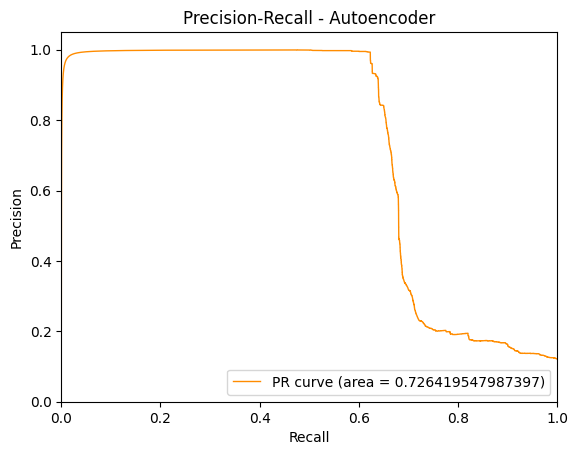

In [ ]:
from pyod.models.auto_encoder import AutoEncoder

# Step 1: Train the AutoEncoder model
clf = AutoEncoder(hidden_neurons=[25, 2, 2, 25], epochs=20, verbose=0)
clf.fit(np.array(normal))

# Step 2: Predict anomalies
test_scores = clf.decision_function(np.array(test))  # Outlier scores
y_ae = clf.predict(np.array(test))  # Binary prediction: 0 for inliers, 1 for outliers/anomalies

# Step 3: Calculate F1-Score, Precision, and Recall
f1 = f1_score(labels, y_ae)
precision = precision_score(labels, y_ae)
recall = recall_score(labels, y_ae)

print(f"F1-Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


# Step 4: Plot AUC-PR Curve
precision, recall, _ = precision_recall_curve(labels, test_scores)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=1, label=f'PR curve (area = {pr_auc})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall - Autoencoder')
plt.legend(loc="lower right")
plt.show()

##Histogram-based Outlier Detection (HBOS) of PyOD

F1-Score: 0.4037935332292309
Precision: 0.27314132878517716
Recall: 0.7740429505135388


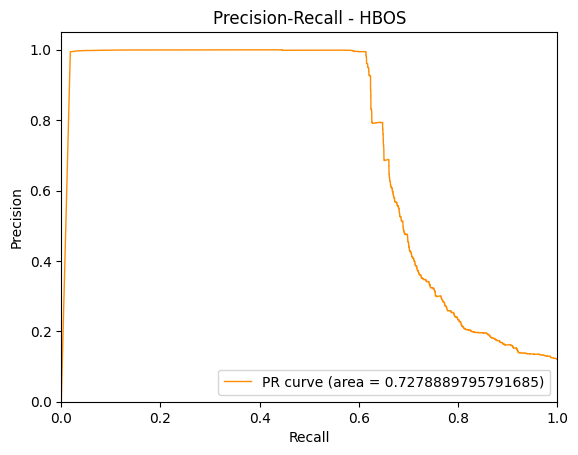

In [ ]:
from pyod.models.hbos import HBOS

# Step 1: Train the HBOS model
clf = HBOS()  # You can adjust parameters as needed
clf.fit(normal)

# Step 2: Predict anomalies
test_scores = clf.decision_function(test)  # Outlier scores
y_hbos = clf.predict(test)  # Binary prediction: 0 for inliers, 1 for outliers/anomalies

# Step 3: Calculate F1-Score, Precision, and Recall
f1 = f1_score(labels, y_hbos)
precision = precision_score(labels, y_hbos)
recall = recall_score(labels, y_hbos)

print(f"F1-Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Step 4: Plot AUC-PR Curve
precision, recall, _ = precision_recall_curve(labels, test_scores)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=1, label=f'PR curve (area = {pr_auc})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall - HBOS')
plt.legend(loc="lower right")
plt.show()